<a href="https://colab.research.google.com/github/aashish959/-LogAnalyticsEngine/blob/main/blackbucks_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark 3.3.2 with Hadoop 3 from a verified mirror
!wget -O spark-3.3.2-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz


--2025-05-24 09:51:37--  https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  14.0MB/s    in 22s     

2025-05-24 09:52:00 (13.1 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]



In [39]:
# Extract Spark
!tar -xzf spark-3.3.2-bin-hadoop3.tgz

# Install findspark to integrate with Colab Python
!pip install -q findspark


In [40]:
import os
import findspark

# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Initialize findspark
findspark.init()

# Create Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LogAnalysis").getOrCreate()

print("✅ Spark session started successfully!")


✅ Spark session started successfully!


In [41]:
from google.colab import files
uploaded = files.upload()


Saving archive (2).zip to archive (2) (1).zip


In [42]:
import zipfile
import os

# Update with actual uploaded filename
zip_path = "/content/archive (2).zip"
extract_path = "/content/logdata"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))


/content/logdata/web-server-access-logs_10k.log


In [43]:
# Download Spark 3.5.5
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz

# Extract the downloaded file
!tar xf spark-3.5.5-bin-hadoop3.tgz


--2025-05-24 09:53:07--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz.2’

spark-3.5.5-bin-had 100%[===================>] 382.16M  16.3MB/s    in 24s     

2025-05-24 09:53:32 (15.7 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz.2’ saved [400724056/400724056]



In [44]:
# Install OpenJDK 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install findspark for Spark integration
!pip install -q findspark


In [45]:
import os

# Set environment variables for Java and Spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

import findspark
findspark.init()


In [46]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("RealTimeLogAnalysis") \
    .getOrCreate()


In [47]:
import os

input_file = "/content/logdata/web-server-access-logs_10k.log"
stream_folder = "/content/logdata_stream"
os.makedirs(stream_folder, exist_ok=True)

chunk_size = 500  # Number of lines per smaller file

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    with open(f"{stream_folder}/log_part_{i//chunk_size}.log", "w") as outfile:
        outfile.writelines(chunk)


In [48]:
from pyspark.sql.functions import regexp_extract, col, when

# Read new files as streaming text lines
logs_stream = spark.readStream.text(stream_folder)

# Regex pattern for parsing Apache log format
pattern = r'(\S+) (\S+) (\S+) \[(.*?)\] "(.*?)" (\d{3}) (\S+)'

# Parse log lines into structured columns
logs_parsed = logs_stream.select(
    regexp_extract("value", pattern, 1).alias("ip"),
    regexp_extract("value", pattern, 2).alias("client"),
    regexp_extract("value", pattern, 3).alias("user"),
    regexp_extract("value", pattern, 4).alias("timestamp"),
    regexp_extract("value", pattern, 5).alias("request"),
    regexp_extract("value", pattern, 6).cast("integer").alias("status"),
    regexp_extract("value", pattern, 7).alias("size")
)

# Convert 'size' column from string to integer, handle '-'
logs_parsed = logs_parsed.withColumn(
    "size",
    when(col("size") == "-", 0).otherwise(col("size").cast("integer"))
)


In [49]:
status_counts = logs_parsed.groupBy("status").count()


In [50]:
query = status_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query.awaitTermination(30)  # Stream for 30 seconds
query.stop()


In [51]:
import shutil
shutil.rmtree("/content/logdata_stream")
os.makedirs("/content/logdata_stream", exist_ok=True)


In [52]:
query = status_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()


In [53]:
import time
import shutil

input_file = "/content/logdata/web-server-access-logs_10k.log"
stream_folder = "/content/logdata_stream"
chunk_size = 500

with open(input_file, "r") as infile:
    lines = infile.readlines()

for i in range(0, len(lines), chunk_size):
    chunk = lines[i:i+chunk_size]
    file_path = f"{stream_folder}/log_part_{i//chunk_size}.log"
    with open(file_path, "w") as outfile:
        outfile.writelines(chunk)
    print(f"Added {file_path}")
    time.sleep(5)  # wait 5 seconds before adding next chunk


Added /content/logdata_stream/log_part_0.log
Added /content/logdata_stream/log_part_1.log
Added /content/logdata_stream/log_part_2.log
Added /content/logdata_stream/log_part_3.log
Added /content/logdata_stream/log_part_4.log
Added /content/logdata_stream/log_part_5.log
Added /content/logdata_stream/log_part_6.log
Added /content/logdata_stream/log_part_7.log
Added /content/logdata_stream/log_part_8.log
Added /content/logdata_stream/log_part_9.log
Added /content/logdata_stream/log_part_10.log
Added /content/logdata_stream/log_part_11.log
Added /content/logdata_stream/log_part_12.log
Added /content/logdata_stream/log_part_13.log
Added /content/logdata_stream/log_part_14.log
Added /content/logdata_stream/log_part_15.log
Added /content/logdata_stream/log_part_16.log
Added /content/logdata_stream/log_part_17.log
Added /content/logdata_stream/log_part_18.log
Added /content/logdata_stream/log_part_19.log
Added /content/logdata_stream/log_part_20.log


In [54]:
query.stop()


In [55]:
print(query.status)
print(query.lastProgress)


{'message': 'Stopped', 'isDataAvailable': False, 'isTriggerActive': False}
{'id': 'ec177ccc-555a-4ffd-af80-6bc8e6be5fa9', 'runId': '15334d92-38b2-4ef2-b48c-7cc55b39d617', 'name': None, 'timestamp': '2025-05-24T09:57:35.793Z', 'batchId': 12, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 2, 'triggerExecution': 3}, 'stateOperators': [{'operatorName': 'stateStoreSave', 'numRowsTotal': 10, 'numRowsUpdated': 0, 'allUpdatesTimeMs': 408, 'numRowsRemoved': 0, 'allRemovalsTimeMs': 0, 'commitTimeMs': 11497, 'memoryUsedBytes': 88840, 'numRowsDroppedByWatermark': 0, 'numShufflePartitions': 200, 'numStateStoreInstances': 200, 'customMetrics': {'loadedMapCacheHitCount': 4400, 'loadedMapCacheMissCount': 0, 'stateOnCurrentVersionSizeBytes': 22560}}], 'sources': [{'description': 'FileStreamSource[file:/content/logdata_stream]', 'startOffset': {'logOffset': 11}, 'endOffset': {'logOffset': 11}, 'latestOffset': None, 'numInputRows': 0, 'inputRow

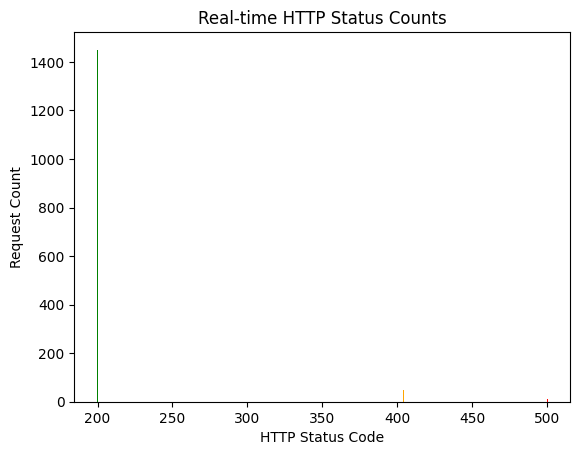

In [56]:
import matplotlib.pyplot as plt

# Sample data (snapshot from streaming output)
status_codes = [200, 404, 500]
counts = [1450, 50, 11]

plt.bar(status_codes, counts, color=['green', 'orange', 'red'])
plt.xlabel('HTTP Status Code')
plt.ylabel('Request Count')
plt.title('Real-time HTTP Status Counts')
plt.show()
